# Asphalt Pavements Performance Prediction Using Tree Ensemble Models

## TLDR
Predict the performance of flexible pavements, specifically the International Roughness Index (IRI), using various Tree Ensemble models.

## Overview:
This notebook contains the code used to train and compare five Tree Ensemble models, namely Random Forest, Gradient Boosting Decision Tree, XGBoost, LightGBM, and CatBoost, for predicting asphalt pavement performance (using IRI as a target). The models are trained using the Long-Term Pavement Performance (LTPP) program data.

## Data Availability:
The dataset used in this study is available at [https://infopave.fhwa.dot.gov/DownloadTracker/Bucket/114229](https://infopave.fhwa.dot.gov/DownloadTracker/Bucket/114229).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Setup visualization parameters
plt.rcParams['figure.dpi'] = 400
sns.set_context('notebook')
sns.set_style("ticks")

In [2]:
# Load and adjust data
df = pd.read_csv('data/processed/data.csv')
df.rename({
    'ACCUMULATED_AADTT': 'AADTT',
}, inplace=True, axis=1)

In [3]:
df.head()

YEAR   THICKNESS   SN  PRECIPITATION  TEMPERATURE     IRI STATION_ID  AGE  \
0  1989  140.566667  6.1    1372.800049         12.0  0.8984    34_1638  4.0   
1  1990  140.566667  6.1    1137.000000         13.8  0.9420    34_1638  5.0   
2  1991  140.566667  6.1    1059.800049         13.9  0.9394    34_1638  6.0   
3  1992  140.566667  6.1     921.700012         12.2  0.8992    34_1638  7.0   
4  1993  140.566667  6.1    1193.599976         12.9  0.9228    34_1638  8.0   

    AADTT  
0  1190.0  
1  2440.0  
2  3870.0  
3  5485.0  
4  6631.0

In [4]:
df.describe().T

count         mean          std          min          25%  \
YEAR           612.0  1996.338235     5.160118  1989.000000  1992.000000   
THICKNESS      612.0   219.975980   205.380087    64.450000   106.700000   
SN             612.0     4.563725     1.539090     2.000000     3.600000   
PRECIPITATION  612.0  1058.423273   458.247140    92.199997   700.850006   
TEMPERATURE    612.0    15.374463     6.062208     2.700000    10.016667   
IRI            612.0     1.388706     0.612876     0.620800     0.906400   
AGE            612.0    16.070261     7.434381     1.000000    10.000000   
AADTT          612.0  2998.134259  4019.191719    11.000000   668.500000   

                       50%          75%         max  
YEAR           1995.500000  1999.000000   2016.0000  
THICKNESS       149.860000   215.250000   1177.0600  
SN                4.200000     5.500000      8.3000  
PRECIPITATION  1140.716675  1444.950012   2091.0000  
TEMPERATURE      16.200001    19.466667     25.9000  
IRI               1.188500     1.742700      4.0048  
AGE              15.500000    21.000000     38.0000  
AADTT          1553.500000  3665.875000  27470.0000

In [5]:
data_clean = df.drop(['STATION_ID'], axis=1)

In [6]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 30000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 50 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='ticks', font_scale=1.6)

g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
g.savefig('img/scatter_matrix.png')

/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


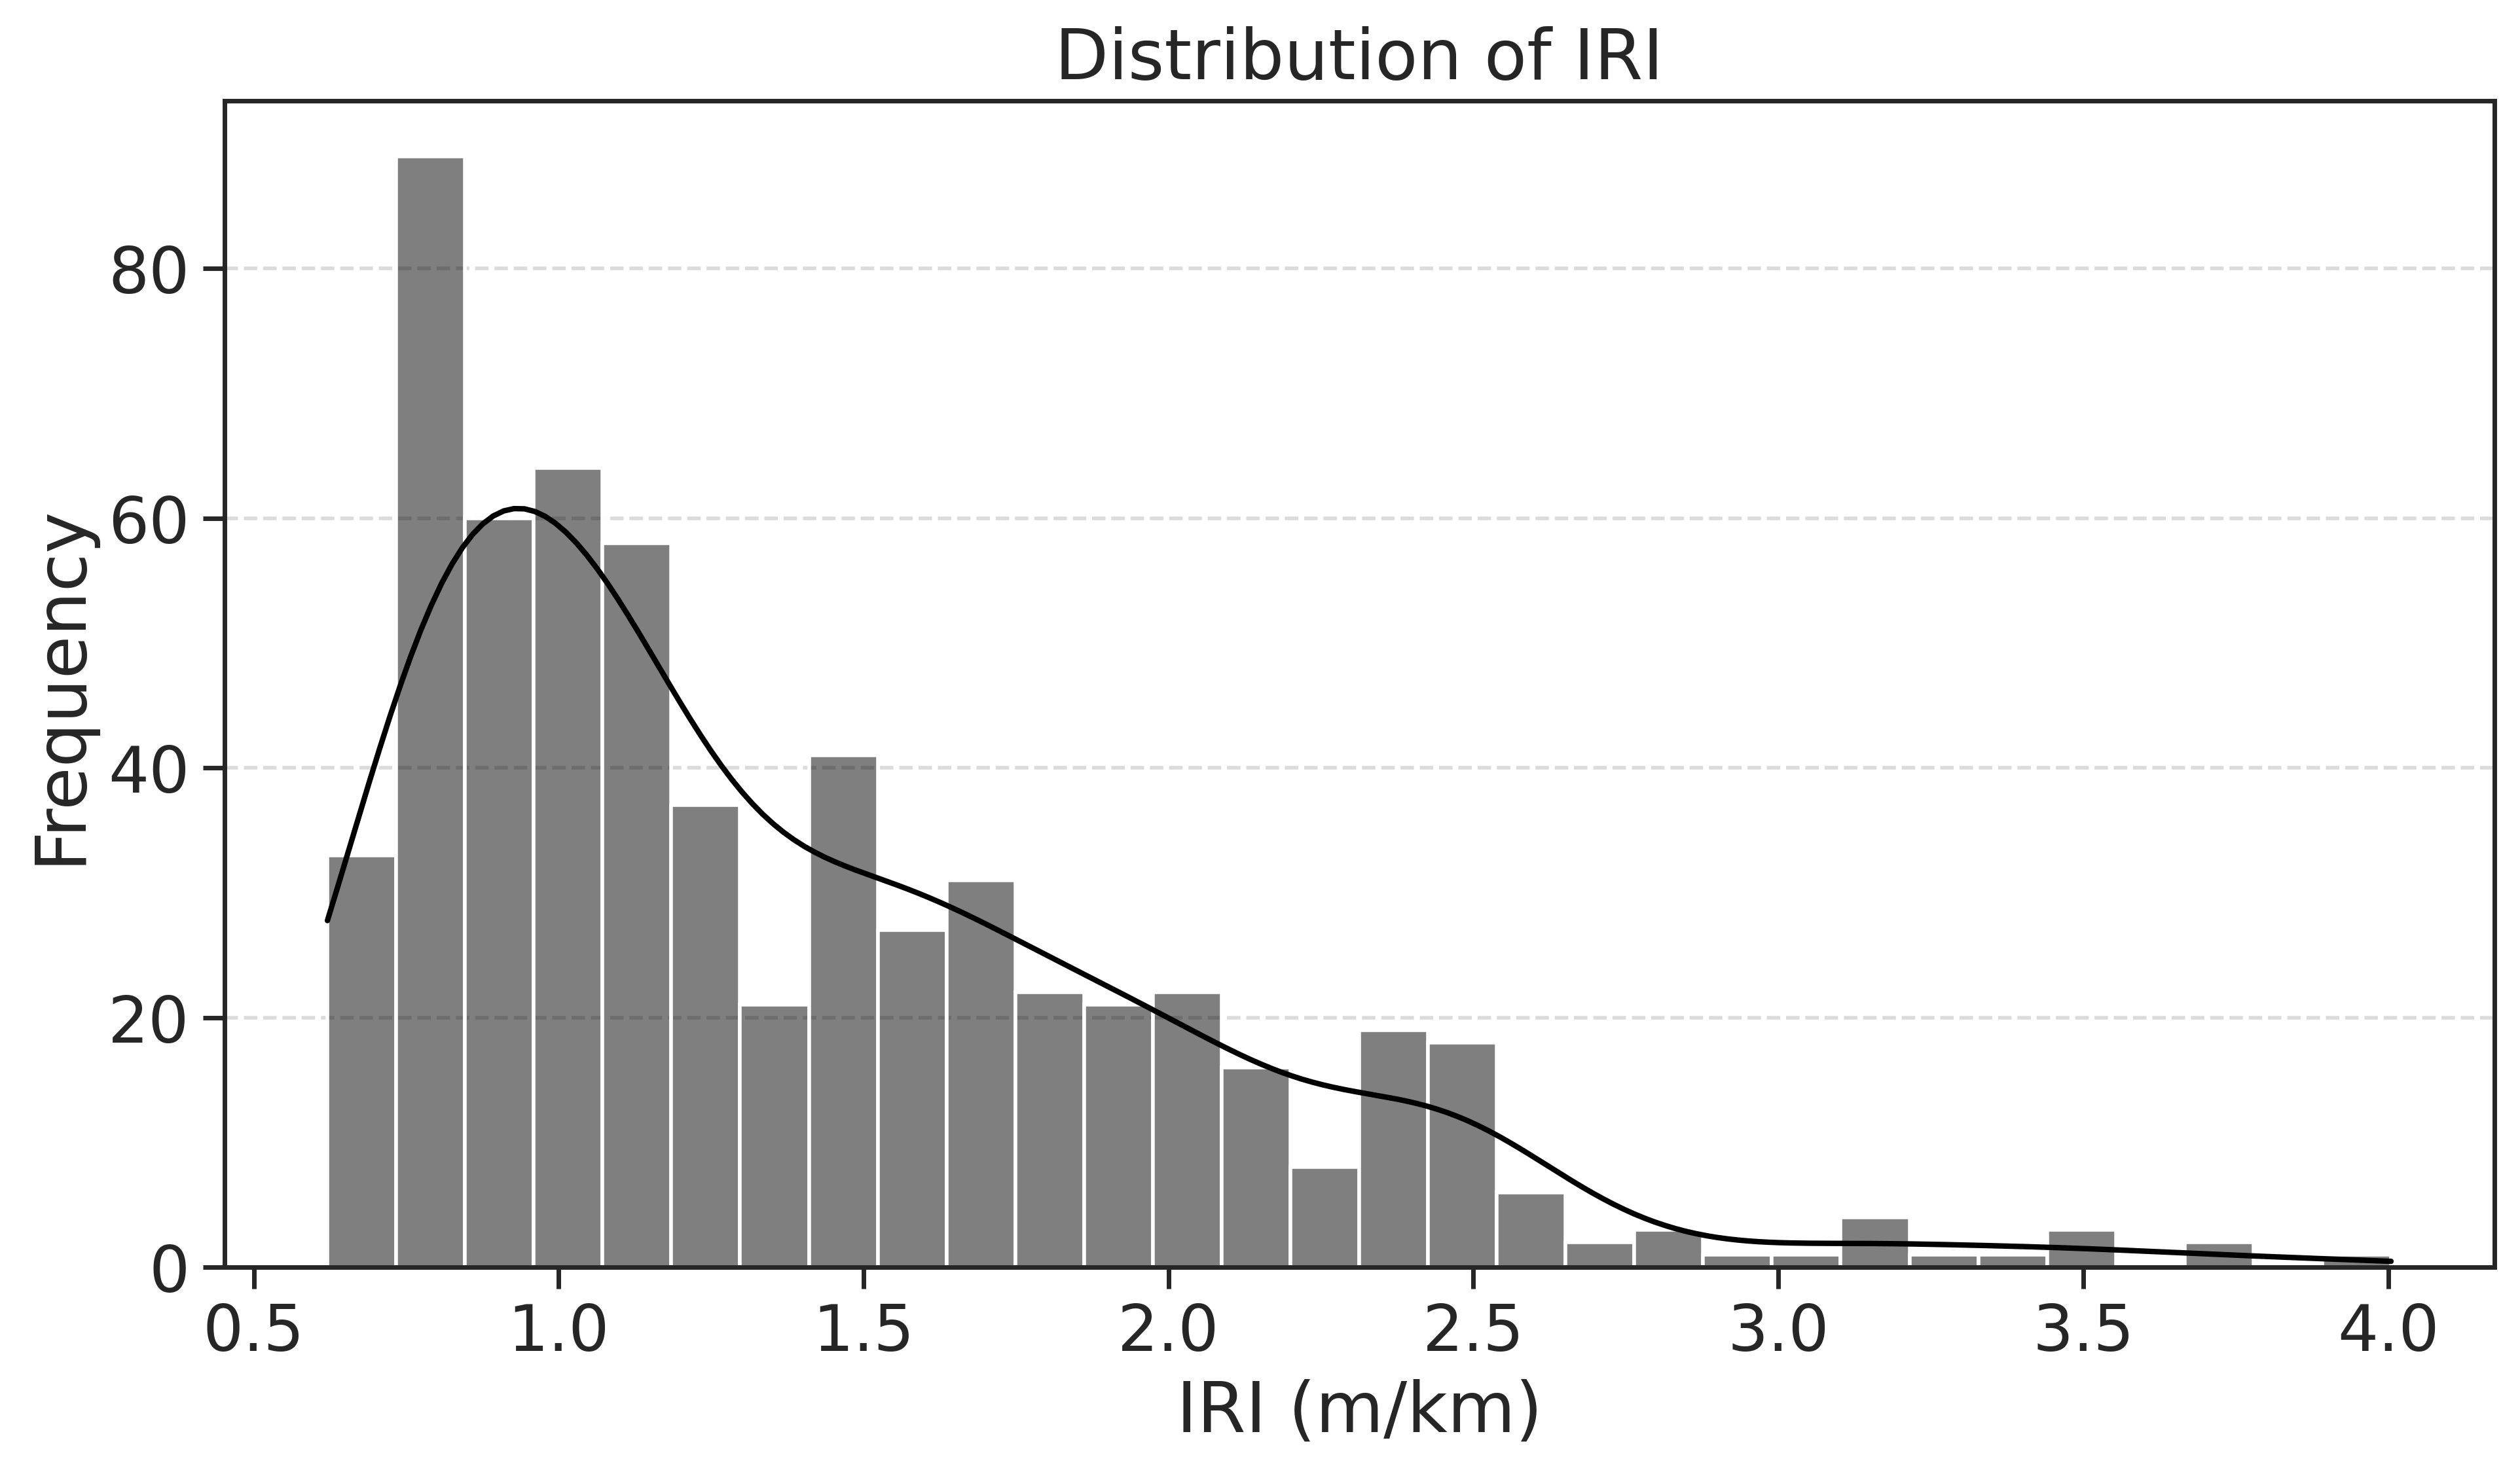

In [7]:
# Plotting IRI Hist
plt.figure(figsize=(10, 6))
sns.histplot(df['IRI'], kde=True, bins=30, color='black')
plt.title('Distribution of IRI')
plt.xlabel('IRI (m/km)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/IRI_Hist.png')
plt.show()


In [8]:
# Data splitting
y = df['IRI']
X = df.drop(['IRI', 'YEAR', 'STATION_ID'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=0)

In [9]:
# Define and train regressors
regressors = {
    'Random Forest': RandomForestRegressor(random_state=42, max_depth=4),
    'GBDT': GradientBoostingRegressor(random_state=42, max_depth=4),
    'XGBoost': xgb.XGBRegressor(random_state=42, max_depth=4),
    'CatBoost': CatBoostRegressor(random_state=42, depth=4, verbose=0),
    'LightGBM': LGBMRegressor(random_state=42, max_depth=4)
}

results = {}
importances = {}

for name, reg in regressors.items():
    reg.fit(X_train, y_train)
    results[name] = reg.predict(X_test)
    if name == "CatBoost":
        normalized_importance = reg.get_feature_importance() / sum(reg.get_feature_importance())
        importances[name] = (normalized_importance * 100).astype(int)
    elif name == "LightGBM":
        normalized_importance = reg.feature_importances_ / sum(reg.feature_importances_)
        importances[name] = (normalized_importance * 100).astype(int)
    else:
        importances[name] = (reg.feature_importances_ * 100).astype(int)


/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 6
[LightGBM] [Info] Start training from score 1.394508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [10]:
# Display feature importances
df_importances = pd.DataFrame(importances, index=X_test.columns)
df_importances.T

THICKNESS  SN  PRECIPITATION  TEMPERATURE  AGE  AADTT
Random Forest         32   7             15           28   11      4
GBDT                  40   8             11           20    9      8
XGBoost               33  20             12           19   10      3
CatBoost              37  13             15           18    7      6
LightGBM              33  14             15           16    9     11

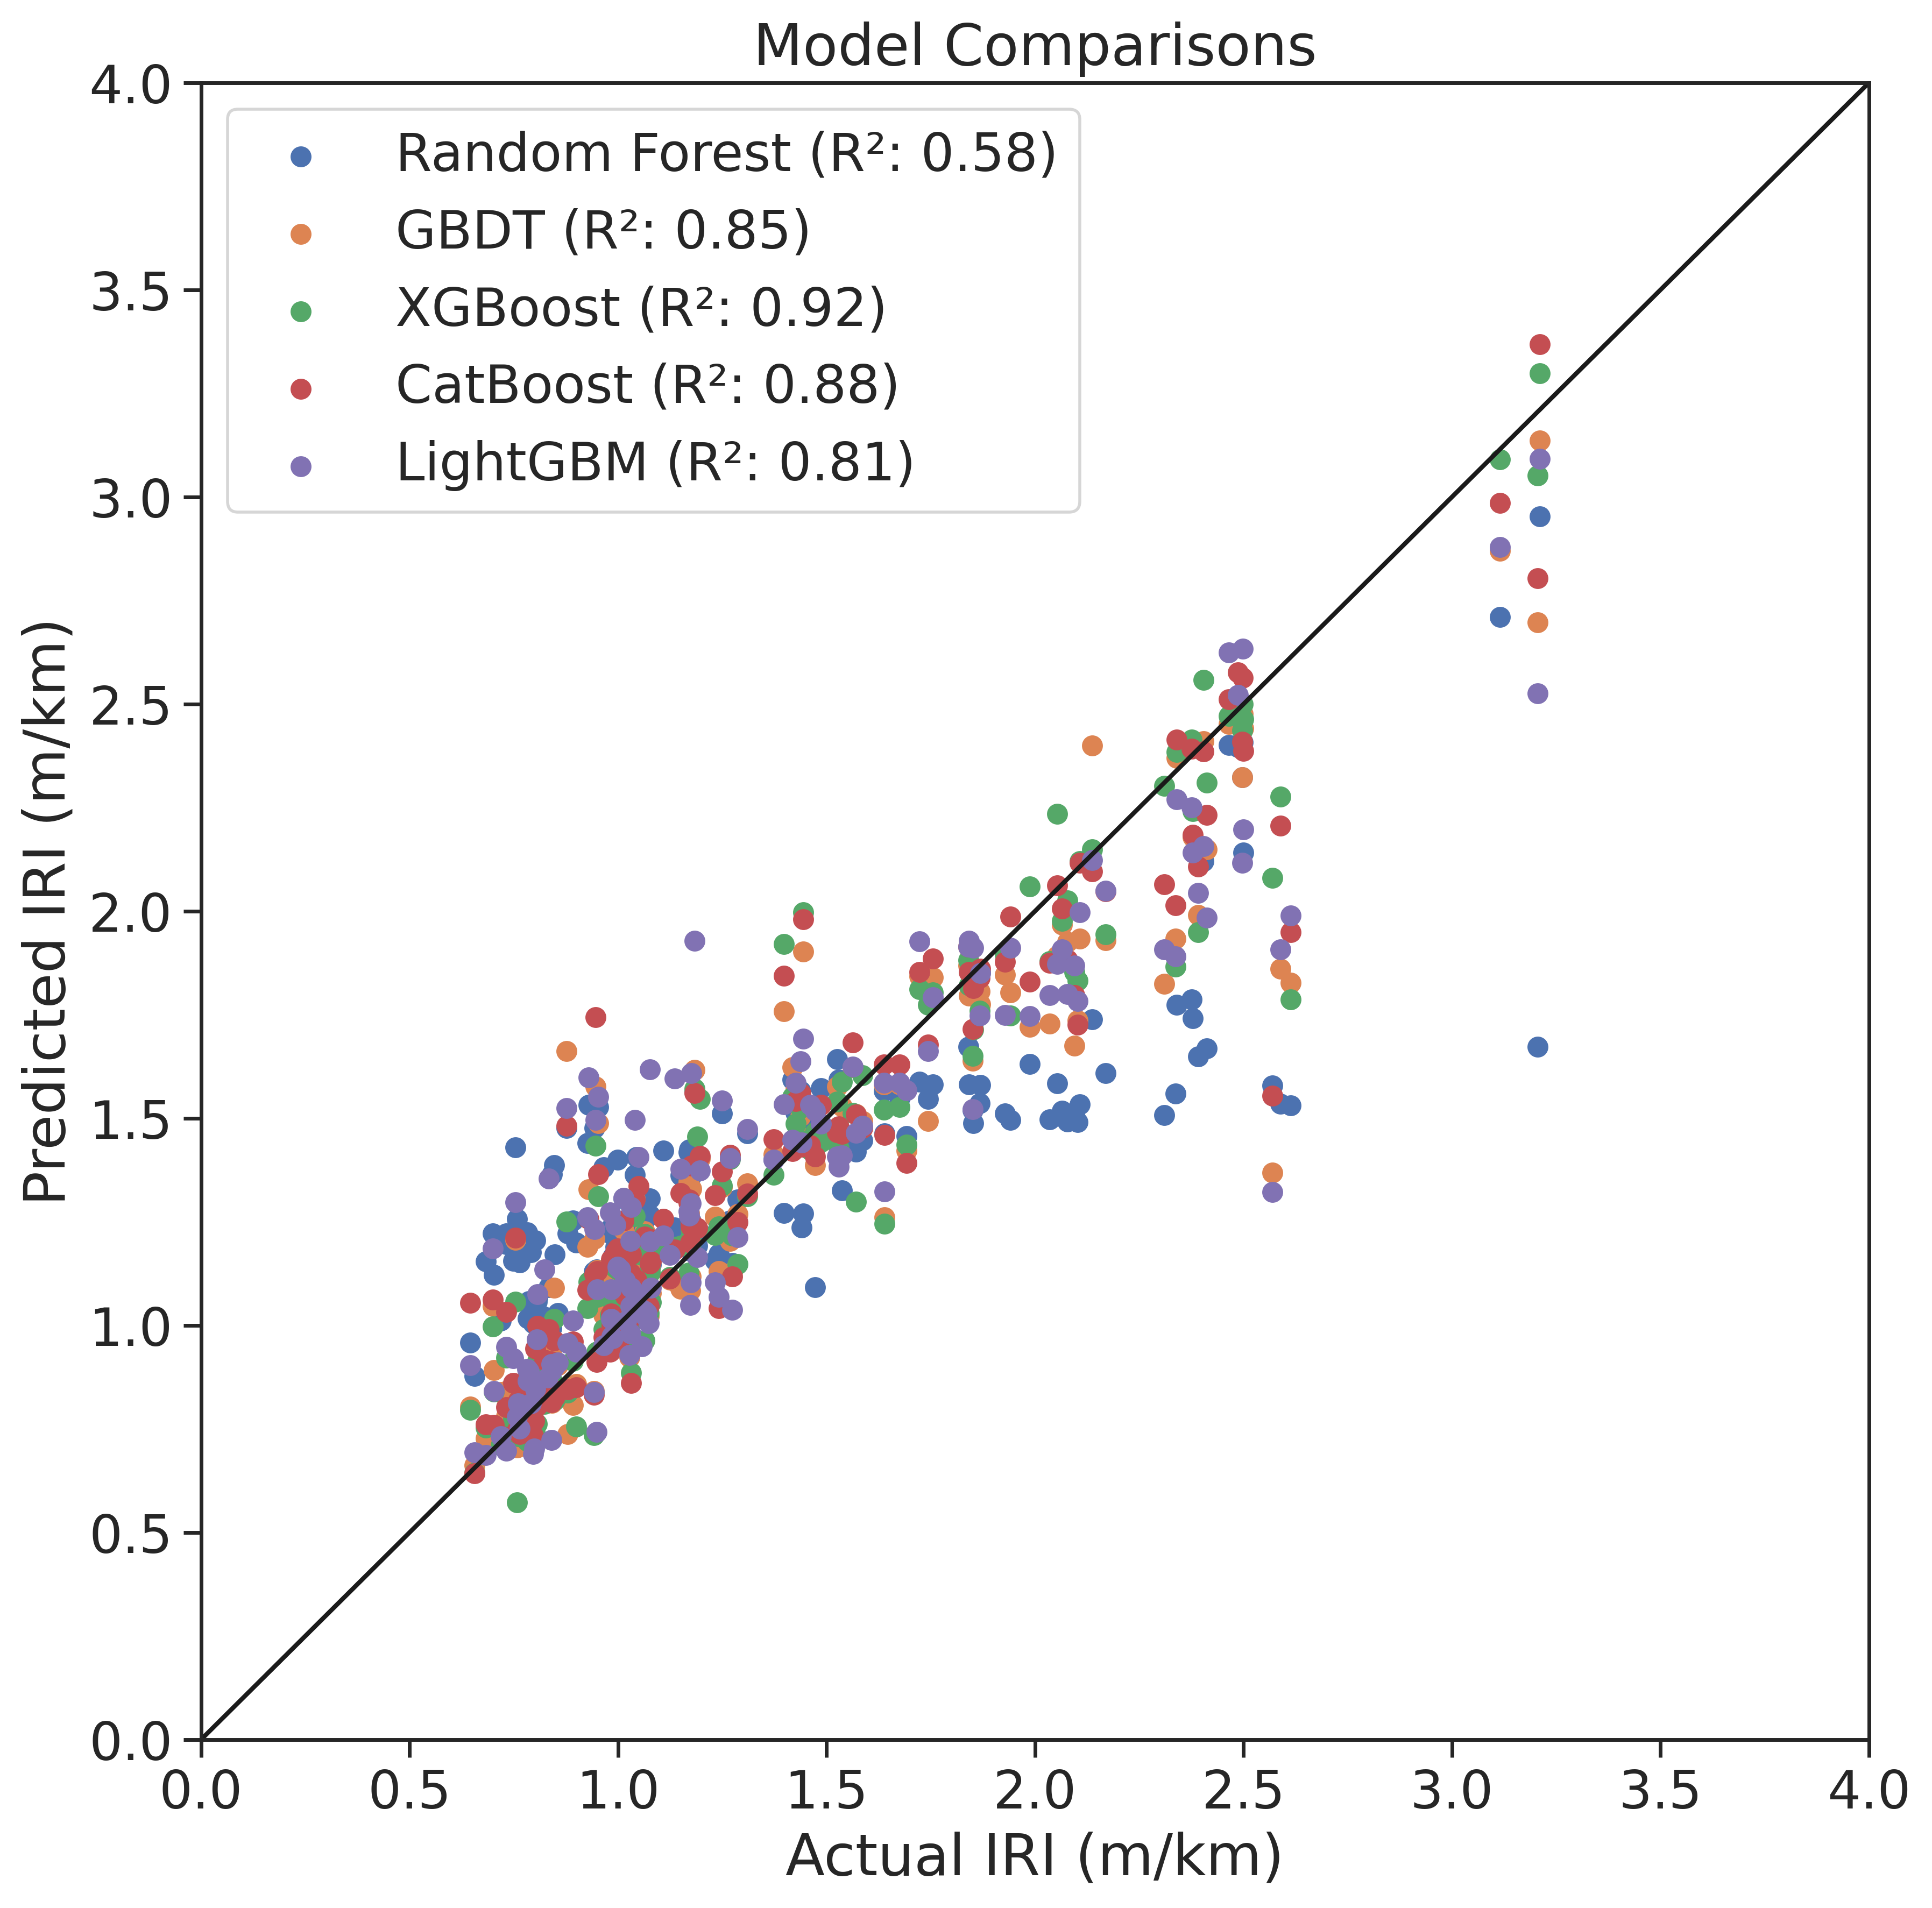

In [11]:
# Metrics calculation and visualization
metrics_data = {
    'Model': [],
    'R2': [],
    'RMSE': [],
    'MAE': []
}

plt.figure(figsize=(10, 10))
identity_line = np.linspace(0, 4, 100)
plt.plot(identity_line, identity_line, 'k-')

# plt.hlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)
# plt.vlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)

for name, preds in results.items():
    metrics_data['Model'].append(name)
    metrics_data['R2'].append(round(r2_score(y_test, preds), 2))
    metrics_data['RMSE'].append(round(mean_squared_error(y_test, preds, squared=False), 2))
    metrics_data['MAE'].append(round(mean_squared_error(y_test, preds), 2))

    plt.scatter(y_test, preds, label=f"{name} (R²: {metrics_data['R2'][-1]})")

plt.axis([0, 4, 0, 4])
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predicted IRI (m/km)')
plt.legend()
plt.title("Model Comparisons")
plt.savefig('img/model_comparisons.png')
plt.show()

In [12]:
# Display metrics
df_metrics = pd.DataFrame(metrics_data)
print(df_metrics)

           Model    R2  RMSE   MAE
0  Random Forest  0.58  0.38  0.15
1           GBDT  0.85  0.23  0.05
2        XGBoost  0.92  0.17  0.03
3       CatBoost  0.88  0.20  0.04
4       LightGBM  0.81  0.26  0.07


In [13]:
# Save models
import pickle

model_paths = {
    'Random Forest': 'models/ltppIRI_RF.mlmodel',
    'GBDT': 'models/ltppIRI_GBDT.mlmodel',
    'XGBoost': 'models/ltppIRI_XGBoost.mlmodel',
    'CatBoost': 'models/ltppIRI_CatBoost.mlmodel',
    'LightGBM': 'models/ltppIRI_LightGBM.mlmodel'
}

for name, reg in regressors.items():
    with open(model_paths[name], 'wb') as f:
        pickle.dump(reg, f)


In [15]:
# Predict IRI
def predict_IRI(model_name, THICKNESS, SN, PRECIPITATION, TEMPERATURE, AGE, AADTT):
    if model_name not in regressors:
        raise ValueError(f"Invalid model: {model_name}")

    input_data = {
        'THICKNESS': [THICKNESS],
        'SN': [SN],
        'PRECIPITATION': [PRECIPITATION],
        'TEMPERATURE': [TEMPERATURE],
        'AGE': [AGE],
        'AADTT': [AADTT]
    }

    input_df = pd.DataFrame(input_data)
    return regressors[model_name].predict(input_df)[0]


# Test: STATION_ID 15_1003, Year 2001. Expected IRI: 2.5.
predicted_value = predict_IRI('XGBoost', 515.6, 5.8, 517, 24, 17, 1574)
predicted_value

/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future 

2.463904

In [16]:
# Code to be adjusted and implemented.

# def predict_future_IRI(model_name, STATION_ID, range_years, SN=None, AADTT=None, PRECIPITATION=None, TEMPERATURE=None):
    
#     # Using global variable df to fetch station details.
#     # Assuming df is your main dataframe that has all the details.
#     station_data = df[df['STATION_ID'] == STATION_ID].iloc[-1]  # Getting the latest data for the STATION_ID
    
#     if not SN:
#         SN = station_data['SN']
    
#     if not PRECIPITATION:
#         PRECIPITATION = station_data['PRECIPITATION']
    
#     if not TEMPERATURE:
#         TEMPERATURE = station_data['TEMPERATURE']
        
#     AGE = station_data['AGE'] + range_years  # Calculating age for the future
    
#     if not AADTT:
#         # Assuming a constant growth rate for AADTT; for more complex forecasting methods you might need additional data.
#         current_AADTT = station_data['AADTT']
#         growth_rate = (current_AADTT - df[df['STATION_ID'] == STATION_ID].iloc[-2]['AADTT']) / current_AADTT
#         AADTT = current_AADTT * (1 + growth_rate) ** range_years
    
#     model = models[model_name]
    
#     # Creating an input array for prediction
#     input_data = np.array([SN, AGE, AADTT, PRECIPITATION, TEMPERATURE]).reshape(1, -1)
    
#     # Predicting the future IRI
#     future_IRI = model.predict(input_data)[0]
    
#     return future_IRI


# predicted_IRI = predict_future_IRI("XGBoost", "15_1004", 10)
# print(f"Predicted IRI for {predicted_IRI[2]} years in the future (using {predicted_IRI[0]}) for STATION_ID {predicted_IRI[1]} is: {predicted_IRI}")